In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install deeptrack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.2/186.2 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 KB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 KB 58.2 MB/s eta 0:00:00
  Created wheel for pint: filename=Pint-0.19.2-py3-none-any.whl size=231018 sha256=c36bb0f0a11b527da16d2eeb6a9e0c102e57b40303e8c77b10b53c455027c1b1
  Stored in directory: /root/.cache/pip/wheels/4e/e3/93/6f

In [3]:
from importlib import reload
import deeptrack as dt
from deeptrack.models.gnns.graphs import GetEdge
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '/content/drive/MyDrive/EXJOBB/training/miguel/spatial_graphs')
import own_graphs
from deeptrack.models.gnns.graphs import GraphExtractor
#from own_graphs import GetEdge as custom_ge
#from own_graphs import EdgeExtractor as custom_ee
from own_graphs import GraphExtractor as custom_graphE
from own_generators import GraphGenerator as custom_gg
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt
own_graphs = reload(own_graphs)
from copy import deepcopy

In [4]:
def get_predictions(dfs, properties, model, **graph_kwargs):
    """
    Get predictions from nodes dataframe.
    Parameters
    ----------
    dfs: DataFrame
        DataFrame containing the nodes.
    properties: dict
        Dictionary containing names of the properties to be used as features.
    model: tf.keras.Model
        Model to be used for predictions.
    graph_kwargs: dict
        Extra arguments to be passed to the graph extractor.
    """
    grapht = custom_graphE(
        nodesdf=dfs, properties=properties, validation=True, **graph_kwargs
    )

    v = [
        np.expand_dims(grapht[0][0][:, 1:], 0),
        np.expand_dims(grapht[0][1], 0),
        np.expand_dims(grapht[0][2][:, 2:], 0),
        np.expand_dims(grapht[0][3], 0),
    ]
    output_edge_f = model(v).numpy()
    pred = output_edge_f#(output_edge_f > 0.5)[0, ...]
    g = grapht[1][1]

    return pred, g, output_edge_f, grapht

def df_from_results(pred, g, output_edge_features, graph_test):
    nodes = graph_test[0][0]
    edges = graph_test[0][2]

    edges = np.append(edges, np.expand_dims(g, axis=-1), axis=-1)
    edges = np.append(edges, pred, axis=-1)

    frame_edges = edges[edges[:, 1] <= np.max(nodes[:, 0])]

    edges_df = pd.DataFrame(
        frame_edges,
        columns=["frame_x", "frame_y", "node_x", "node_y", "gt", "prediction"],
    )
    edges_df["score"] = output_edge_features[0]

    edges_df["frame_diff"] = edges_df["frame_y"] - edges_df["frame_x"]

    return edges_df, nodes, 

def scale_solution(inputdf, a_scale = 1, p_scale = 1):
    # This function normalizes all separate dimensions of the solution, and optionally adds a scaling factor to the active and/or passive force
    df = inputdf.copy()
    n = df.shape[0]
    maxima = np.zeros(4)
    #finding max
    for i in df.index:
        for j in range(4):
            if maxima[j] < np.abs(df.at[i, "solution"][j]):
                maxima[j] = abs(df.at[i, "solution"][j])
    #scaling
    scales = np.array([a_scale, a_scale, p_scale, p_scale])/maxima
    for i in df.index:
        for j in range(4):
            df.at[i, "solution"][j] = df.at[i, "solution"][j] * scales[j]
    return df, scales

def set_real_labels(nodesdf):
  last_frame = 0
  label_val = 0
  for i in list(nodesdf.index):
    current_frame = nodesdf.at[i, "frame"]
    if current_frame > last_frame:
      label_val = 0
    nodesdf.at[i, "label"] = label_val
    label_val += 1
    last_frame = current_frame
    
def shuffle_frames(df):
  dfcpy = df.copy()
  previous_set = df["set"].copy()
  dfgrouping = dfcpy.groupby(["frame"])
  dfs = [_df for _, _df in dfgrouping]
  random.shuffle(dfs)
  catdf = pd.concat(dfs)
  n_rows = catdf.shape[0]
  new_indices = np.arange(n_rows)
  catdf = catdf.set_index(new_indices)
  #catdf["set"] = previous_set.to_numpy()
  return catdf

def setstoframe(df):
  dfcpy = df.copy()
  framecol = deepcopy(dfcpy["frame"])
  dfcpy["set"] = framecol
  return dfcpy


In [5]:
data_dict = np.load("/content/drive/MyDrive/EXJOBB/datasets/tslj/N14 samples10 F_P60COLAB.npy", allow_pickle=True).item() # load data
## Extract some variables and leave only the dictionary which will be input to the graph extractor
box_len = data_dict['box_len']
del data_dict['box_len']
interaction_radius = data_dict['interaction_radius']
del data_dict["interaction_radius"]
potential_type = data_dict['potential_type']
del data_dict["potential_type"]

## A pandas dataframe is needed as input to the graph extractor.
nodesdf = pd.DataFrame.from_dict(data_dict)
n_detections = nodesdf.shape[0]

## Normalize node centroids and orientations
max_vals = {"centroid-0" : box_len/2, "centroid-1" : box_len/2, "orientation" : np.pi*2, 'frame': nodesdf["frame"].max(), "solution0": nodesdf["solution"]}
for key in ["centroid-0", "centroid-1", "orientation"]:
  nodesdf.loc[:, key] = nodesdf.loc[:, key] / max_vals[key]

## Scale the box length and interaction length as much as the centroids
scaled_interaction_radius = interaction_radius/max_vals["centroid-0"]
scaled_box_len = box_len/max_vals["centroid-0"]

## Normalize the solution vector elements and ev. add extra scaling
p_scale = 10
nodesdf, scales = scale_solution(nodesdf, p_scale=p_scale)

## Set the labels of the particles
#nodesdf["label"] = np.arange(0, nodesdf.shape[0])
#nodesdf.loc[250:, "label"] = 1
nodesdf.loc[:, "label"] = 0
set_real_labels(nodesdf)

## Cut out a validation set, the rest is the training set.
n_particles = int(nodesdf.index.max()+1) / (nodesdf.loc[:, "frame"].max()+1)
val_ratio = 0.1#0.0010
tmp_val_rows = int(val_ratio*nodesdf.shape[0])
i = tmp_val_rows
while np.mod(i, n_particles) != 0:
    i += 1
cutoff_index = i
val_rows = cutoff_index
val_nodesdf = nodesdf.loc[:cutoff_index-1, :]
train_nodesdf = nodesdf.loc[cutoff_index:, :]



## Set the sets so that each frame is seen as one video
train_nodesdf = setstoframe(train_nodesdf)

## Shuffle the frames in the training set, and re-index
train_nodesdf = shuffle_frames(train_nodesdf)   


radius = scaled_interaction_radius
print(f"Scaled interaction radius becomes {scaled_interaction_radius} length units, with box length {scaled_box_len}")



Scaled interaction radius becomes 0.8092026376136825 length units, with box length 2.0


In [ ]:
data_dict = np.load("/content/drive/MyDrive/EXJOBB/datasets/tslj/mixed1000samplesFP60.npy", allow_pickle=True).item()
box_len = data_dict['box_len']
del data_dict['box_len']
interaction_radius = data_dict['interaction_radius']
del data_dict["interaction_radius"]
potential_type = data_dict['potential_type']
del data_dict["potential_type"]
nodesdf = pd.DataFrame.from_dict(data_dict)
n_detections = nodesdf.shape[0]

#normalize node centroids and orientations
max_vals = {"centroid-0" : box_len/2, "centroid-1" : box_len/2, "orientation" : np.pi*2, 'frame': nodesdf["frame"].max(), "solution0": nodesdf["solution"]}
for key in ["centroid-0", "centroid-1", "orientation"]:
  nodesdf.loc[:, key] = nodesdf.loc[:, key] / max_vals[key]
scaled_interaction_radius = interaction_radius/max_vals["centroid-0"]
scaled_box_len = box_len/max_vals["centroid-0"]
p_scale = 10
nodesdf, scales = scale_solution(nodesdf, p_scale=p_scale)
# arange and 1s gives 26
# real labels gives 24

#nodesdf["label"] = np.arange(0, nodesdf.shape[0])
#nodesdf.loc[250:, "label"] = 1
nodesdf.loc[:, "label"] = 0
def set_real_labels(nodesdf):
  last_frame = 0
  label_val = 0
  for i in list(nodesdf.index):
    current_frame = nodesdf.at[i, "frame"]
    if current_frame > last_frame:
      label_val = 0
    nodesdf.at[i, "label"] = label_val
    label_val += 1
    last_frame = current_frame
def shuffle_frames(df):
  dfcpy = df.copy()
  dfgrouping = dfcpy.groupby(["frame"])
  dfs = [_df for _, _df in dfgrouping]
  random.shuffle(dfs)
  catdf = pd.concat(dfs)
  return catdf
  


set_real_labels(nodesdf)

radius = scaled_interaction_radius
print(f"Scaled interaction radius becomes {scaled_interaction_radius} length units, with box length {scaled_box_len}")



Scaled interaction radius becomes 0.8740387444736634 length units, with box length 2.0


In [ ]:
train_nodesdf["set"].to_numpy().max()

9

Histogram

In [ ]:
graph = custom_graphE(train_nodesdf, properties=['centroid-0', 'centroid-1', 'orientation'], radius=radius, box_len=scaled_box_len)


NameError: ignored

Text(0.5, 1.0, 'Pairwise distance histogram')

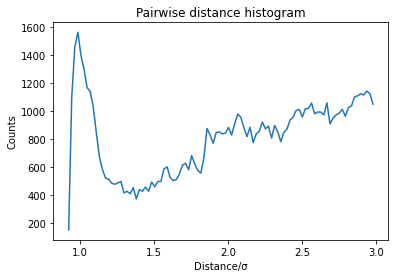

In [ ]:
distances = graph[0][1]
histogram, hist_vals = np.histogram(distances, bins=100)
histogram
hist_vals = hist_vals*max_vals["centroid-0"]
hist_vals

plt.plot(hist_vals[:-1], histogram)
plt.xlabel("Distance/\u03C3")
plt.ylabel("Counts")
plt.title("Pairwise distance histogram")


In [ ]:

train_graph = own_graphs.GraphExtractor(
    train_nodesdf, 
    properties=['centroid-0', 'centroid-1', 'orientation'], 
    radius=radius, box_len=scaled_box_len,
    output_type='nodes'
    ) 
'''
train_graph = dt.models.gnns.graphs.GraphExtractor(
    train_nodesdf, 
    properties=['centroid-0', 'centroid-1', 'orientation'], 
    radius=radius, box_len=scaled_box_len,
    output_type='nodes'
    ) 
'''

Creating graph edges...


100%|██████████| 9/9 [00:00<00:00,  9.78it/s]


"\ntrain_graph = dt.models.gnns.graphs.GraphExtractor(\n    train_nodesdf, \n    properties=['centroid-0', 'centroid-1', 'orientation'], \n    radius=radius, box_len=scaled_box_len,\n    output_type='nodes'\n    ) \n"

In [ ]:
train_nodesdf

In [ ]:
train_graph[2]

(array([[ 6,  0],
        [ 6,  1],
        [ 6,  2],
        [ 6,  3],
        [ 6,  4],
        [ 6,  5],
        [ 6,  6],
        [ 6,  7],
        [ 6,  8],
        [ 6,  9],
        [ 6, 10],
        [ 6, 11],
        [ 6, 12],
        [ 6, 13],
        [ 9,  0],
        [ 9,  1],
        [ 9,  2],
        [ 9,  3],
        [ 9,  4],
        [ 9,  5],
        [ 9,  6],
        [ 9,  7],
        [ 9,  8],
        [ 9,  9],
        [ 9, 10],
        [ 9, 11],
        [ 9, 12],
        [ 9, 13],
        [ 4,  0],
        [ 4,  1],
        [ 4,  2],
        [ 4,  3],
        [ 4,  4],
        [ 4,  5],
        [ 4,  6],
        [ 4,  7],
        [ 4,  8],
        [ 4,  9],
        [ 4, 10],
        [ 4, 11],
        [ 4, 12],
        [ 4, 13],
        [ 5,  0],
        [ 5,  1],
        [ 5,  2],
        [ 5,  3],
        [ 5,  4],
        [ 5,  5],
        [ 5,  6],
        [ 5,  7],
        [ 5,  8],
        [ 5,  9],
        [ 5, 10],
        [ 5, 11],
        [ 5, 12],
        [ 

In [ ]:
train_nodesdf

In [ ]:
df = train_nodesdf.groupby(["frame"])
dfs = [_df for _, _df in df]
n_particles = dfs[0].shape[0]
new_indices = np.arange(n_particles)
for idf in dfs:        
    idf.reset_index(drop=True, inplace=True)
dfx = dfs[5:7]
dfx

[    label  centroid-0  centroid-1  orientation  \
 0       0   -0.609168    0.686998     0.750956   
 1       1   -0.814191    0.155694     0.273340   
 2       2   -0.010495    0.561487     0.154514   
 3       3   -0.384889    0.535422     0.594359   
 4       4    0.297148    0.494210     0.732158   
 5       5    0.203170   -0.854540     0.636745   
 6       6   -0.107989   -0.595608     0.504438   
 7       7   -0.986696    0.500801     0.365730   
 8       8   -0.668717   -0.686523     0.463094   
 9       9    0.262216   -0.294748     0.835292   
 10     10   -0.130367   -0.149801     0.137075   
 11     11   -0.125641   -0.881293     0.145354   
 12     12   -0.493737    0.241648     0.581067   
 13     13   -0.513405   -0.104888     0.076548   
 
                                              solution  frame  set  
 0   [0.006008552915086356, -1.0, -6.39021355868346...      5    0  
 1   [-0.14613771589584998, 0.9892837204954266, 0.9...      5    0  
 2   [0.5646497603196099, 

In [ ]:
train_graph[0][2][:]  

array([[126, 127],
       [126, 128],
       [126, 129],
       ...,
       [125, 121],
       [125, 122],
       [125, 124]])

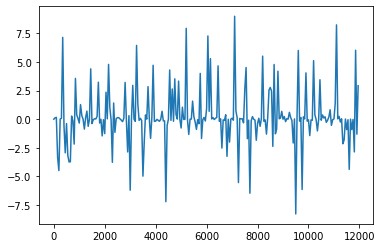

In [ ]:
plt.plot(np.arange(train_graph[1][0][:,3].shape[0])[::50], train_graph[1][0][:,3][::50])

In [6]:
generator = custom_gg(
    nodesdf,#train_nodesdf, 
    properties=['centroid-0', 'centroid-1', 'orientation'], 
    radius=radius, box_len=scaled_box_len, 
    batch_size=12,
    min_data_size=24, 
    max_data_size=36, 
    max_epochs_per_sample=2
    ) 



Creating graph edges...


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


In [7]:
model = dt.models.gnns.MPNGNN(
    dense_layer_dimensions = (10, 20, 40), 
    base_layer_dimensions = (40, 40),
    number_of_node_features=3, #remember to change to 3
    number_of_edge_features=1,
    number_of_node_outputs = 4, #remember to change to 4
    number_of_edge_outputs = 0,
    number_of_global_outputs = 0,
    output_type = 'nodes',
    node_output_activation='linear',
)

# previous model had setup 10 20 40     40 40
# the model that gave 0 all the time was 64 96   96 96 96
# then, learning rate was at 0.001, testing 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # dont know if last run had this lr or a smaller one
    loss = 'mae',
    #metrics=['accuracy'], # apparently accuracy gives a type error somewhere
)



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
def first_alternative(val_nodesdf):
    dfcpy = val_nodesdf.copy()
    dfgrouping = dfcpy.groupby(["frame"])
    dfs = [_df for _, _df in dfgrouping]

    vs = ()
    node_features = []
    edge_features = []
    edges = []
    edge_weights = []

    for df in dfs:
        graph = custom_graphE(
            df, ["centroid-0", "centroid-1", "orientation"], validation=True, radius=radius, output_type='nodes', box_len=scaled_box_len
        )

        v = [
            np.expand_dims(graph[0][0][:, 1:], 0), #in the end should be (batch, number of nodes, number of features)
            np.expand_dims(graph[0][1], 0),
            np.expand_dims(graph[0][2][:, 2:], 0),
            np.expand_dims(graph[0][3], 0),
        ]

        node_features.append(v[0])
        edge_features.append(v[1])
        edges.append(v[2])
        edge_weights.append(v[3])

    
    return (node_features, edge_features, edges, edge_weights)

def second_alternative(val_nodesdf): #trying just one batch
    dfcpy = val_nodesdf.copy()
    dfgrouping = dfcpy.groupby(["frame"])
    dfs = [_df for _, _df in dfgrouping]

    node_features = []
    edge_features = []
    edges = []
    edge_weights = []

    for df in dfs:
        graph = custom_graphE(
            df, ["centroid-0", "centroid-1", "orientation"], validation=True, radius=radius, output_type='nodes', box_len=scaled_box_len
        )

        v = (
            np.expand_dims(graph[0][0][:, 1:], 0), #in the end should be (batch, number of nodes, number of features)
            np.expand_dims(graph[0][1], 0),
            np.expand_dims(graph[0][2][:, 2:], 0),
            np.expand_dims(graph[0][3], 0),
        )

    return v # last one 
    
def third_alternative(val_nodesdf):
    graph = own_graphs.GraphExtractor(
        val_nodesdf, ["centroid-0", "centroid-1", "orientation"], validation=True, radius=radius, output_type='nodes', box_len=scaled_box_len
    )

    v = [
        np.expand_dims(graph[0][0][:, 1:], 0), #in the end should be (batch, number of nodes, number of features)
        np.expand_dims(graph[0][1], 0),
        np.expand_dims(graph[0][2][:, 2:], 0),
        np.expand_dims(graph[0][3], 0),
    ]

    
    return v

In [9]:
val_data = third_alternative(val_nodesdf)
solutions = val_nodesdf["solution"].to_list()#[1199-12:-1]
plotter1 = dt.visualization.training.TrainingLossPlotter(loss_names=["loss"])
callback = dt.visualization.callbacks.VisualizationCallback(plotters=[plotter1]),# plotter2])
tf.metrics.get("mae")

Creating graph edges...


100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


<function keras.losses.mean_absolute_error(y_true, y_pred)>

In [14]:
n_batches = int(val_rows/n_particles)
#val_targets = np.reshape(np.array(val_targets), (n_batches, n_particles) + (np.array(val_targets).shape[-1],))
val_targets = np.zeros((n_batches, int(n_particles), 4))
for i in range(n_batches):
    for j in range(int(n_particles)):
        val_targets[i,j,:] = solutions[i*int(n_particles) + j]
val_targets = np.expand_dims(solutions, axis=0)

14.0

In [15]:
def mae(a,b):
    sum = 0
    for i in range(len(a[0])):
        sum += np.linalg.norm(a[0,i,:] - b[0,i,:], ord=2)
    return sum/(i+1)/4
mae(model(val_data), val_targets)

def shuffle_and_reset_generator(train_nodesdf):
    df = shuffle_frames(train_nodesdf)    
    generator = custom_gg(
        df, 
        properties=['centroid-0', 'centroid-1', 'orientation'], 
        radius=radius, box_len=scaled_box_len, 
        batch_size=12,
        min_data_size=24, 
        max_data_size=36, 
        max_epochs_per_sample=2
    ) 
    return generator
    

In [16]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

n_breaks = 4
n_epochs = 100
n_sub_epochs = int(n_epochs/n_breaks)
validation_history = []
histories = []
for i in range(n_breaks):
    val_err = mae(model(val_data), val_targets)
    print(f"Validation loss: {val_err} at iteration {(i+1)*n_breaks - 1}")
    validation_history.append(val_err)
    generator = shuffle_and_reset_generator(train_nodesdf) #now nodesdf........
    with generator:
        history = model.fit(generator, epochs=n_sub_epochs, callbacks=[callback])#, validation_data=(val_data, solutions)) # the val data gets extracted incorrectly after having been passed through the model
    histories.append(history)
    
    



Validation loss: 1.016301459499768 at iteration 3
Creating graph edges...


100%|██████████| 9/9 [00:00<00:00, 14.84it/s]
Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.9/dist-packages/deeptrack/generators.py", line 382, in _continuous_get_training_data
    new_image = self._get(self.feature)
  File "/usr/local/lib/python3.9/dist-packages/deeptrack/generators.py", line 426, in _get
    return features.resolve()
  File "/usr/local/lib/python3.9/dist-packages/deeptrack/features.py", line 179, in __call__
    output = super(Feature, self).__call__(_ID=_ID)
  File "/usr/local/lib/python3.9/dist-packages/deeptrack/backend/core.py", line 275, in __call__
    new_value = utils.safe_call(self.action, _ID=_ID)
  File "/usr/local/lib/python3.9/dist-packages/deeptrack/utils.py", line 162, in safe_call
    return function(*positional_

    glob_labels = labels[2][randset]
  File "/usr/local/lib/python3.9/dist-packages/deeptrack/image.py", line 363, in __getitem__
    out = self._value.__getitem__(idx)
IndexError: index 9 is out of bounds for axis 0 with size 9


KeyboardInterrupt: ignored

Saving history

In [ ]:
from absl.flags import FlagHolder
for i in range(len(histories)):
  history = histories[i]
  hist_df = pd.DataFrame(history.history)
  
  hist_csv_file = f'/content/drive/MyDrive/EXJOBB/training/miguel/histories/histories1/history{i}.csv'
  with open(hist_csv_file, mode='w') as f:
      hist_df.to_csv(f)

In [ ]:
validation_history

[0.8906618517178756,
 0.5576943583213366,
 0.5237040221691132,
 0.47873035359841126]

In [ ]:
val_txt = f'/content/drive/MyDrive/EXJOBB/training/miguel/validation_histories/valhist1.txt'
with open(val_txt, "w") as output:
  output.write(str(validation_history))

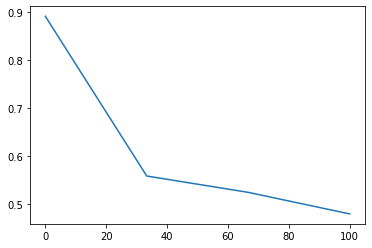

In [ ]:
plt.plot(np.linspace(0, n_epochs, n_breaks), validation_history)

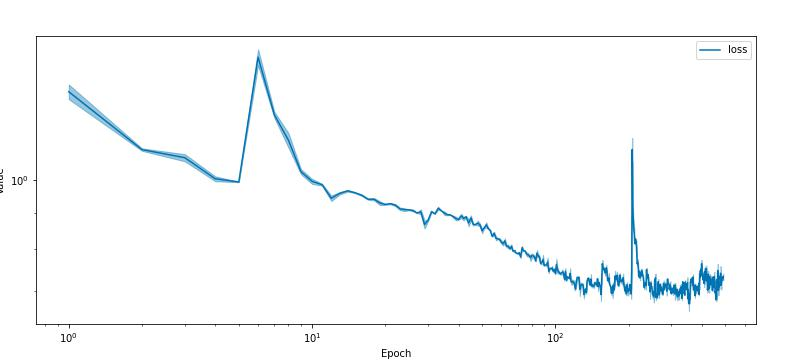

2/2 [==============================] - 1s 581ms/step - loss: 0.7249


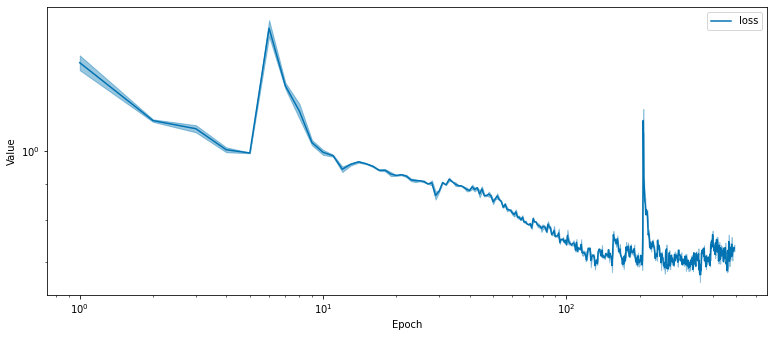

In [ ]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.01)
#lr: 0.001 for 200 epochs. then 0.01
n_breaks = 1
n_epochs = 100
n_sub_epochs = int(n_epochs/n_breaks)
for i in range(n_breaks):
    val_err = mae(model(val_data), val_targets)
    print(f"Validation loss: {val_err} at iteration {(i+1)*n_breaks - 1}")
    validation_history.append(val_err)
    generator = shuffle_and_reset_generator(train_nodesdf)
    with generator:
        history = model.fit(generator, epochs=n_sub_epochs, callbacks=[callback])#, validation_data=(val_data, solutions)) # the val data gets extracted incorrectly after having been passed through the model
    histories.append(history)

# Evaluation
1. Check passive force wrt distance by moving 2 particles closer to each other
2. Check active force by having some particles rotating (having just one likely leads to errors due to lack of edges)


Must make sure that the scaling of the interaction radius is the same in the validation data as in the training data

# Passive force testing (2 particles with varying distance)

Setup test data the same way as training data (remember that box length and interaction length must be the same as in the training data)

In [ ]:
a_scale = 1

test_data_dict = np.load("/content/drive/MyDrive/EXJOBB/datasets/Test/tslj/passiveFP60.npy", allow_pickle=True).item()
test_box_len = test_data_dict['box_len']
del test_data_dict['box_len']

test_interaction_radius = test_data_dict['interaction_radius']
del test_data_dict["interaction_radius"]
del test_data_dict["potential_type"]
test_nodesdf = pd.DataFrame.from_dict(test_data_dict)
RR = pd.DataFrame.from_dict(test_data_dict)
#normalize node centroids and orientations
test_max_vals = {"centroid-0" : box_len/2, "centroid-1" : box_len/2, "orientation" : np.pi*2, 'frame': test_nodesdf["frame"].max()} # Must be same box length that the model was trained on
for key in ["centroid-0", "centroid-1", "orientation"]:
  test_nodesdf.loc[:, key] = test_nodesdf.loc[:, key] / test_max_vals[key]
test_scaled_interaction_radius = test_interaction_radius/test_max_vals["centroid-0"]
if scaled_interaction_radius != test_interaction_radius/test_max_vals["centroid-0"]:
  raise Exception(f" Training radius {scaled_interaction_radius} vs validation radius {test_scaled_interaction_radius}. Scaling is not the same.")
test_scaled_box_len = test_box_len/test_max_vals["centroid-0"]

#nodesdf["label"] = np.arange(0, nodesdf.shape[0])
#nodesdf.loc[250:, "label"] = 1
test_nodesdf.loc[:, "label"] = 0

#print(nodesdf)
set_real_labels(test_nodesdf)

In [ ]:
test_nodesdf.loc[56, "solution"]

array([6.00000000e+01, 0.00000000e+00, 6.52719926e-02, 1.16862468e-18])

In [ ]:
test_nodesdf

,label,centroid-0,centroid-1,orientation,solution,frame,set
0,0,0.000000,0.000000e+00,0.0,"[60.0, 0.0, -0.0, -0.0]",0,0
1,1,0.809203,0.000000e+00,0.5,"[-60.0, 7.34788079488412e-15, -0.0, -0.0]",0,0
2,0,0.003269,0.000000e+00,0.0,"[60.0, 0.0, -0.0, -0.0]",1,0
3,1,0.805933,4.003589e-19,0.5,"[-60.0, 7.34788079488412e-15, -0.0, -0.0]",1,0
4,0,0.006538,0.000000e+00,0.0,"[60.0, 0.0, -0.0, -0.0]",2,0
...,...,...,...,...,...,...,...
195,1,0.532647,4.562653e-17,0.5,"[-60.0, 7.34788079488412e-15, 59.7956471436722...",97,0
196,0,0.276581,-7.467074e-18,0.0,"[60.0, 0.0, -59.8654032375201, -1.266533815037...",98,0
197,1,0.532638,4.670532e-17,0.5,"[-60.0, 7.34788079488412e-15, 59.8656827066168...",98,0
198,0,0.276587,-8.168793e-18,0.0,"[60.0, 0.0, -59.91156533900366, -1.30977863129...",99,0


Get predictions

In [ ]:
full_test_graph = custom_graphE(
    test_nodesdf, ["orientation", "centroid-0", "centroid-1"], validation=True, radius=radius, output_type='nodes', box_len=test_scaled_box_len
)
distances = full_test_graph[0][1]
true_active = full_test_graph[1][0][2:,0]
true_passive = full_test_graph[1][0][2:,2]
edges = full_test_graph[0][2][:, 2:]
v = [
    np.expand_dims(full_test_graph[0][0][:, 1:], 0),
    np.expand_dims(full_test_graph[0][1], 0),
    np.expand_dims(full_test_graph[0][2][:, 2:], 0),
    np.expand_dims(full_test_graph[0][3], 0),
]
model_predictions = model(v).numpy()
model_predictions[0, :, 0] = model_predictions[0, :, 0] / scales[0]
model_predictions[0, :, 1] = model_predictions[0, :, 1] / scales[1]
model_predictions[0, :, 2] = model_predictions[0, :, 2] / scales[2]
model_predictions[0, :, 3] = model_predictions[0, :, 3] / scales[3]


Creating graph edges...


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


In [ ]:
full_test_graph[0][0][:, 1:]/2

Plotting

'\npred_active_x = model_predictions[0][:, 0]\npred_active_y = model_predictions[0][:, 1]\nax_particle_0 = true_active[-100:-1:2]\npred_ax_paritcle_0 = pred_active_x[-100:-1:2]\npred_ay_paritcle_0 = pred_active_y[-100:-1:2]\n\nplt.sca(axs[1])\nplt.plot(d_particle_0*max_vals["centroid-0"], ax_particle_0)\nplt.plot(d_particle_0*max_vals["centroid-0"], pred_ax_paritcle_0)\nplt.plot(d_particle_0*max_vals["centroid-0"], pred_ay_paritcle_0)\nplt.title("Active force")\nplt.legend(["Ground truth x", "Prediction x", "Prediction y"])\nplt.xlabel("Distance/σ")\nplt.ylabel("Force")\npred_passive_x\nplt.show()\n'

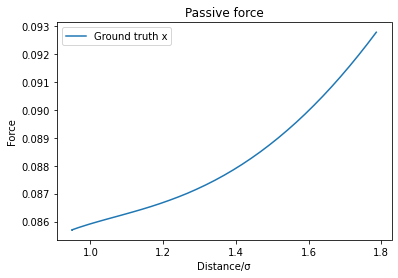

In [ ]:

# Note that the particles move towards each other, meaning that the the first graph essentially goes from right to left timewise.
# The orientation of the first particle was always 0 radians, and pi radians for the second particle.

import matplotlib.pyplot as plt

pred_passive_x = model_predictions[0][:, 2] 
pred_passive_y = model_predictions[0][:, 3]
d_particle_0 = distances[:,0][-100:-1:2]
px_particle_0 = true_passive[-100:-1:2]
pred_px_paritcle_0 = pred_passive_x[-100:-1:2]
pred_py_paritcle_0 = pred_passive_y[-100:-1:2]

#plt.plot(d_particle_0*max_vals["centroid-0"], px_particle_0)
plt.plot(d_particle_0*box_len/2, pred_px_paritcle_0)
#plt.plot(d_particle_0*max_vals["centroid-1"], pred_py_paritcle_0)
plt.title("Passive force")
plt.legend(["Ground truth x", "Prediction x", "Prediction y"])
plt.xlabel("Distance/\u03C3")
plt.ylabel("Force")
'''
pred_active_x = model_predictions[0][:, 0]
pred_active_y = model_predictions[0][:, 1]
ax_particle_0 = true_active[-100:-1:2]
pred_ax_paritcle_0 = pred_active_x[-100:-1:2]
pred_ay_paritcle_0 = pred_active_y[-100:-1:2]

plt.sca(axs[1])
plt.plot(d_particle_0*max_vals["centroid-0"], ax_particle_0)
plt.plot(d_particle_0*max_vals["centroid-0"], pred_ax_paritcle_0)
plt.plot(d_particle_0*max_vals["centroid-0"], pred_ay_paritcle_0)
plt.title("Active force")
plt.legend(["Ground truth x", "Prediction x", "Prediction y"])
plt.xlabel("Distance/\u03C3")
plt.ylabel("Force")
pred_passive_x
plt.show()
'''

In [ ]:
pred_passive_x

array([0.69196147, 0.6842046 , 0.23090929, 0.23127621, 0.23084915,
       0.23121397, 0.23078775, 0.2311497 , 0.23072292, 0.23108223,
       0.23065557, 0.23101416, 0.23058692, 0.23094359, 0.23051545,
       0.23087132, 0.23044237, 0.23079452, 0.2303662 , 0.23071656,
       0.23028837, 0.23063582, 0.23020688, 0.23055315, 0.23012355,
       0.23046705, 0.23003632, 0.2303783 , 0.22994733, 0.23028779,
       0.22985469, 0.23019312, 0.2297593 , 0.23009484, 0.22966106,
       0.22999512, 0.22956003, 0.22989114, 0.22945476, 0.22978452,
       0.22934456, 0.2296735 , 0.22923283, 0.22955923, 0.22911757,
       0.22944102, 0.22899742, 0.2293202 , 0.22887392, 0.22919317,
       0.22874613, 0.2290633 , 0.2286134 , 0.22892937, 0.228477  ,
       0.22879015, 0.22833537, 0.22864729, 0.22819   , 0.22849926,
       0.22803834, 0.22834575, 0.2278829 , 0.22818804, 0.22772166,
       0.22802351, 0.22755365, 0.22785434, 0.22738071, 0.22767974,
       0.22720173, 0.22749843, 0.2270163 , 0.22731076, 0.22682

# Active force testing (2 distant particles with varying orientation)

In [ ]:

test_data_dict = np.load("/content/drive/MyDrive/EXJOBB/datasets/Test/tslj/activeFP60.npy", allow_pickle=True).item()
test_box_len = test_data_dict['box_len']
del test_data_dict['box_len']

test_interaction_radius = test_data_dict['interaction_radius']
del test_data_dict["interaction_radius"]
del test_data_dict["potential_type"]
test_nodesdf = pd.DataFrame.from_dict(test_data_dict)

#normalize node centroids and orientations
test_max_vals = {"centroid-0" : test_box_len/2, "centroid-1" : test_box_len/2, "orientation" : np.pi*2, 'frame': test_nodesdf["frame"].max()}
for key in ["centroid-0", "centroid-1", "orientation"]:
  test_nodesdf.loc[:, key] = test_nodesdf.loc[:, key] / test_max_vals[key]
test_scaled_interaction_radius = test_interaction_radius/test_max_vals["centroid-0"]
if scaled_interaction_radius != test_interaction_radius/test_max_vals["centroid-0"]:
  raise Exception(f" Training radius {scaled_interaction_radius} vs validation radius {test_scaled_interaction_radius}. Scaling is not the same.")
test_scaled_box_len = test_box_len/test_max_vals["centroid-0"]

# arange and 1s gives 26
# real labels gives 24

#nodesdf["label"] = np.arange(0, nodesdf.shape[0])
#nodesdf.loc[250:, "label"] = 1
test_nodesdf.loc[:, "label"] = 0
#print(nodesdf)
set_real_labels(test_nodesdf)
print(test_nodesdf.at[70, "solution"])


[-36.32597444  47.7537808   -0.          -0.        ]


In [ ]:
full_test_graph = custom_graphE(
    test_nodesdf, ["centroid-0", "centroid-1", "orientation"], validation=True, radius=100, output_type='nodes', box_len=test_scaled_box_len
)
distances = full_test_graph[0][1]
true_active_x = full_test_graph[1][0][2:,0]
true_passive_x = full_test_graph[1][0][2:,2]
orientations = full_test_graph[0][0][:,3]

v = [
    np.expand_dims(full_test_graph[0][0][:, 1:], 0),
    np.expand_dims(full_test_graph[0][1], 0),
    np.expand_dims(full_test_graph[0][2][:, 2:], 0),
    np.expand_dims(full_test_graph[0][3], 0),
]
model_predictions = model(v).numpy()
model_predictions[0, :, 0] = model_predictions[0, :, 0] / scales[0]
model_predictions[0, :, 1] = model_predictions[0, :, 1] / scales[1]
model_predictions[0, :, 2] = model_predictions[0, :, 2] / scales[2]
model_predictions[0, :, 3] = model_predictions[0, :, 3] / scales[3]


Creating graph edges...


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


In [ ]:
orientations

array([0.    , 0.    , 0.0101, 0.0101, 0.0202, 0.0202, 0.0303, 0.0303,
       0.0404, 0.0404, 0.0505, 0.0505, 0.0606, 0.0606, 0.0707, 0.0707,
       0.0808, 0.0808, 0.0909, 0.0909, 0.101 , 0.101 , 0.1111, 0.1111,
       0.1212, 0.1212, 0.1313, 0.1313, 0.1414, 0.1414, 0.1515, 0.1515,
       0.1616, 0.1616, 0.1717, 0.1717, 0.1818, 0.1818, 0.1919, 0.1919,
       0.202 , 0.202 , 0.2121, 0.2121, 0.2222, 0.2222, 0.2323, 0.2323,
       0.2424, 0.2424, 0.2525, 0.2525, 0.2626, 0.2626, 0.2727, 0.2727,
       0.2828, 0.2828, 0.2929, 0.2929, 0.303 , 0.303 , 0.3131, 0.3131,
       0.3232, 0.3232, 0.3333, 0.3333, 0.3434, 0.3434, 0.3535, 0.3535,
       0.3636, 0.3636, 0.3737, 0.3737, 0.3838, 0.3838, 0.3939, 0.3939,
       0.404 , 0.404 , 0.4141, 0.4141, 0.4242, 0.4242, 0.4343, 0.4343,
       0.4444, 0.4444, 0.4545, 0.4545, 0.4646, 0.4646, 0.4747, 0.4747,
       0.4848, 0.4848, 0.4949, 0.4949, 0.505 , 0.505 , 0.5151, 0.5151,
       0.5252, 0.5252, 0.5353, 0.5353, 0.5454, 0.5454, 0.5555, 0.5555,
      

Text(0, 0.5, 'Force')

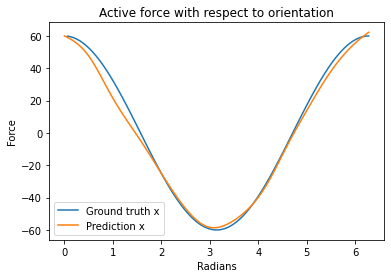

In [ ]:
pred_active_x = model_predictions[0][:, 0]
pred_active_y = model_predictions[0][:, 1]
pred_passive_x = model_predictions[0][:, 2]
pred_passive_y = model_predictions[0][:, 3]

orientations_particle_0 = orientations[::2]
pred_active_x_particle_0 = pred_active_x[::2]
pred_active_y_particle_0 = pred_active_y[::2]
pred_passive_x_particle_0 = pred_passive_x[::2]
pred_passive_y_particle_0 = pred_passive_y[::2]

plt.plot(orientations_particle_0[1:] * np.pi * 2, true_active_x[::2])
plt.plot(orientations_particle_0 * np.pi * 2, pred_active_x_particle_0)
plt.title("Active force with respect to orientation")
plt.legend(["Ground truth x", "Prediction x"])
plt.xlabel("Radians")
plt.ylabel("Force")

0          0
1          0
2          0
3          0
4          0
        ... 
11995    999
11996    999
11997    999
11998    999
11999    999
Name: frame, Length: 12000, dtype: int64


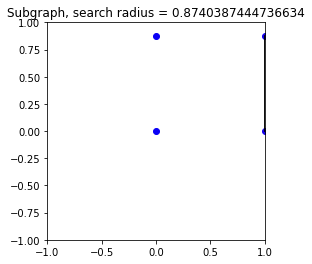

In [ ]:

output=full_test_graph
fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title(f"Subgraph, search radius = {radius}")
plt.xlim([-1,1])
plt.ylim([-1,1])
length =10
centroids = output[0][0][:length, 0:2]
edges = output[0][2][:length*length, 2:]
frames = output[0][2][:length*length, :1]
print(nodesdf["frame"])
color_v = plt.cm.brg(np.linspace(0,1,1+frames.max()))

for i in range(length):
  plt.scatter(centroids[i,0], centroids[i,1], color=color_v[frames[i]])


for i in range(edges.shape[0]):
  if edges[i, 0] < length and edges[i, 1] < length:
    plt.plot([centroids[edges[i,0]][0], centroids[edges[i,1]][0]],[centroids[edges[i,0]][1], centroids[edges[i,1]][1]], color='k')
plt.show()



In [ ]:
centroids

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.74038744e-01],
       [1.00000000e+00, 3.53111653e-03],
       [1.00000000e+00, 8.70507628e-01],
       [2.00000000e+00, 7.06223306e-03],
       [2.00000000e+00, 8.66976511e-01],
       [3.00000000e+00, 1.05933496e-02],
       [3.00000000e+00, 8.63445395e-01],
       [4.00000000e+00, 1.41244661e-02],
       [4.00000000e+00, 8.59914278e-01]])

# Graph plotter that only works for spatial graphs in validation mode with true labels

Since the graph is plotted here, if the graph is input to the model, this shows whether or not the graph is correctly connected.

Creating graph edges...


100%|██████████| 1/1 [01:49<00:00, 109.49s/it]


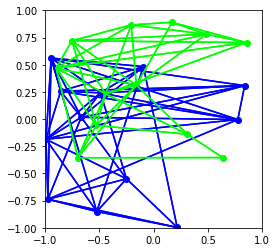

In [ ]:
#graph = full_test_graph
#n_rows = train_nodesdf.shape[0]
#new_indices = np.arange(n_rows)
#train_nodesdf = train_nodesdf.set_index(new_indices)
graph = custom_graphE(train_nodesdf, properties=['centroid-0', 'centroid-1', 'orientation'], radius=radius, box_len=scaled_box_len, validation=True)
#graph = full_test_graph
start_frame = 0
for count, f in enumerate((graph[0][0][:,0])):
  frame = int(f)
  if count==0:
    start_frame = frame
  if frame > start_frame:
    break
n_particles = count
preframes_removed_for_val = 1
frame_vector = np.array([20,70]) # The frames to be used for the plot. Last frame index not included



fcentroids = graph[0][0][:, :]
edges = graph[0][2][:,:]
mincframe = frame_vector.min()
maxcframe = frame_vector.max()
n_frames = maxcframe - mincframe
xmax = np.abs(graph[0][0][:,1]).max()
ymax = np.abs(graph[0][0][:,2]).max()


color_v = plt.cm.brg(np.linspace(0,1,n_frames+1))
#first plot all centroids that are in the frame window, then draw lines based on edges in the frame window
plt.xlim([-1,1])
plt.ylim([-1,1])
ax = plt.gca()
ax.set_aspect('equal')
centroids = fcentroids[:, 1:3]

for edge in edges:
  frame = edge[0]
  if frame in frame_vector:
    ci = int(frame - mincframe)
    centroid1 = centroids[edge[2], :]
    centroid2 = centroids[edge[3], :]
    plt.plot([centroid1[0], centroid2[0]], [centroid1[1],centroid2[1]], color=color_v[ci])
for fcentroid in fcentroids:
  frame = fcentroid[0]
  #print(fcentroid)
  if frame in frame_vector:
    ci = int(frame - mincframe)
    plt.scatter(fcentroid[1], fcentroid[2], color=color_v[ci])


    
plt.show()

#centroid(edge) is not the same as centroid(frame_of_edge)
#The edges of frame x connect the nodes of frame x+1
#frame 105 (training nodesdf for ver4) is example of this
# Reason: the index that the edge is refering to is the index of the node when all nodes from the original dataframe are stacked. When I create the validation frame I remove some 

In [ ]:
fcentroids

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  8.74038744e-01,  0.00000000e+00,
         5.00000000e-01],
       [ 1.00000000e+00,  3.53111653e-03,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000000e+00,  8.70507628e-01,  4.32437055e-19,
         5.00000000e-01],
       [ 2.00000000e+00,  7.06223306e-03,  0.00000000e+00,
         0.00000000e+00],
       [ 2.00000000e+00,  8.66976511e-01,  8.64874111e-19,
         5.00000000e-01],
       [ 3.00000000e+00,  1.05933496e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 3.00000000e+00,  8.63445395e-01,  1.29731117e-18,
         5.00000000e-01],
       [ 4.00000000e+00,  1.41244661e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 4.00000000e+00,  8.59914278e-01,  1.72974822e-18,
         5.00000000e-01],
       [ 5.00000000e+00,  1.76555826e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00000000e+00,  8.56383162e-01,  2.16218528e-18,
      

# Save model

In [ ]:
extra_string = 'wcapromising'
model.save('/content/drive/MyDrive/EXJOBB/models/mpn_trained/here/' + extra_string)

# Load models

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/EXJOBB/training/miguel/trained_models/tslj/0activeforce')